In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
import missingno 
from pytz import timezone
import pytz

## Data cleaning and preprocessing

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


From these we can see that 4 datetime columns are strings instead of datetime objects

In [3]:
df.describe()

,UNIXTime,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
count,3.268600e+04,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000
mean,1.478047e+09,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869
std,3.005037e+06,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474
min,1.472724e+09,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000
25%,1.475546e+09,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000
50%,1.478026e+09,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000
75%,1.480480e+09,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000
max,1.483265e+09,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000


We notice that Radiation and Humidity have a high standard deviation which implies that the values are more spread around the mean. We will inspect this more later.


<AxesSubplot:>

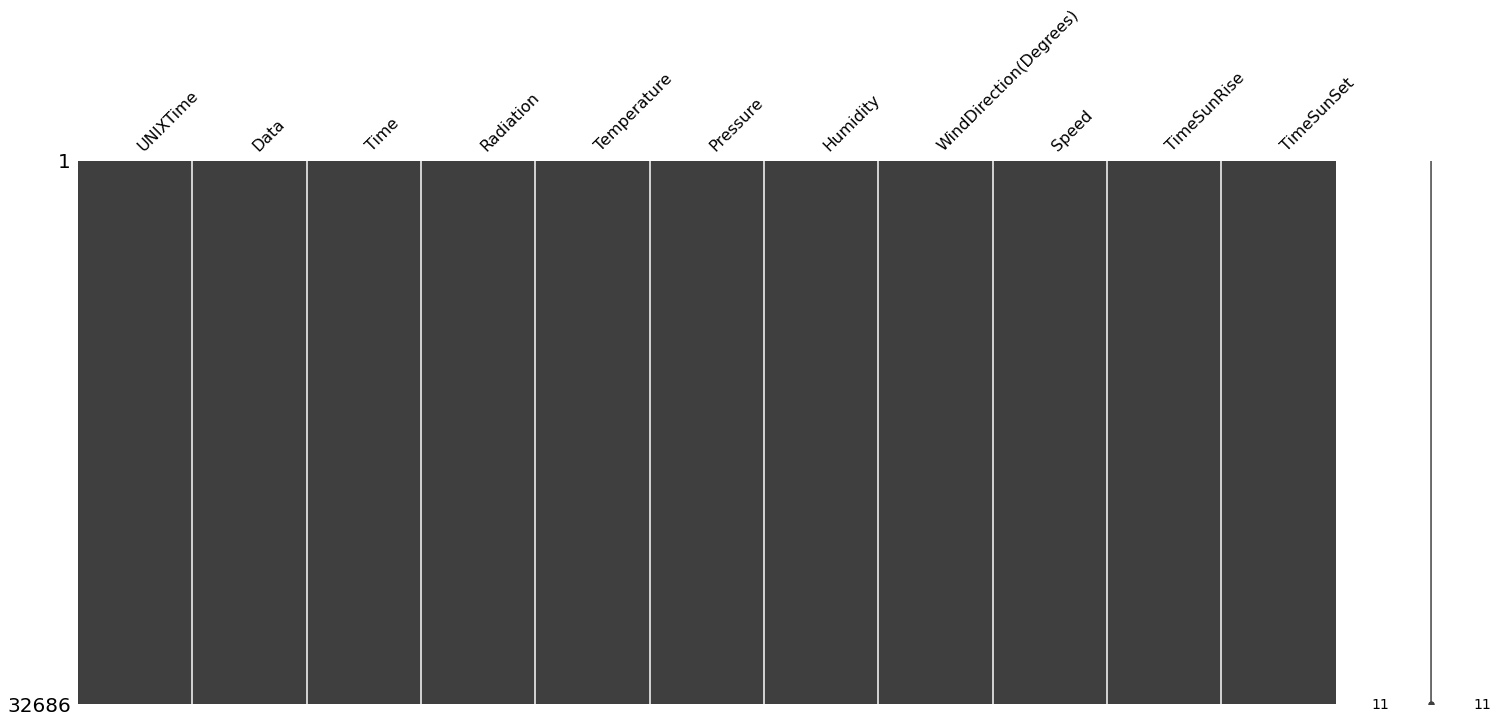

In [4]:
missingno.matrix(df)

In [5]:
df.columns

Index(['UNIXTime', 'Data', 'Time', 'Radiation', 'Temperature', 'Pressure',
       'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeSunRise',
       'TimeSunSet'],
      dtype='object')

In [6]:
import re

In [7]:
def preprocess_data(df):

    """
    Description:
        Convert timezone to Hawaii
        Rename some of the columns
        Convert string columns to datetime objects
        add new feature from TimeSunSet and TimeSunRise columns
    
    Args:
        val: input df (DataFrame)
        
    Returns:
        df -> preprocessed DataFrame
    """

    #'Data' - all elements contain the same value.
    #we have UNIXTime so we can drop Time.
    df.drop(['Data','Time'],axis=1,inplace=True)

    # index by UNIX time
    df['UNIXTime'] = pd.to_datetime(df['UNIXTime'], unit='s')
    df.sort_values('UNIXTime', inplace=True) # sort by UNIXTime
    df.set_index('UNIXTime',inplace=True) # index by UNIXTime
    
     # Localize the index (using tz_localize) to UTC (to make the Timestamps timezone-aware) and then convert to Eastern (using tz_convert)
    hawaii= timezone('Pacific/Honolulu')
    df.index = df.index.tz_localize(pytz.utc).tz_convert(hawaii)

    #rename some of the columns
    df.rename(columns={'WindDirection(Degrees)': 'WindDirection', 'Speed': 'WindSpeed'}, inplace=True)

    #convert string columns to datetime objects
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.week
    df['month'] = df.index.month
    df['hour'] = df.index.hour 
    df['Date'] = df.index.date

    #extract sunrise and sunrise hour and minute
    df['SunriseHour'] = df['TimeSunRise'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunriseMinute'] = df['TimeSunRise'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df['SunsetHour'] = df['TimeSunSet'].apply(lambda x: re.search(r'^\d+', x).group(0)).astype(np.int)
    df['SunsetMinute'] = df['TimeSunSet'].apply(lambda x: re.search(r'(?<=:)\d+(?=:)',x).group(0)).astype(np.int)

    df.drop(['TimeSunRise', 'TimeSunSet'],axis=1,inplace = True)
    
    return df

In [8]:
df = preprocess_data(df)
df.head()

<ipython-input-7-5b22c56403b1>:35: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['week_of_year'] = df.index.week


,Radiation,Temperature,Pressure,Humidity,WindDirection,WindSpeed,day_of_month,week_of_year,month,hour,Date,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute
UNIXTime,,,,,,,,,,,,,,,
2016-09-01 00:00:08-10:00,2.58,51,30.43,103,77.27,11.25,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:05:10-10:00,2.83,51,30.43,103,153.44,9.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:20:06-10:00,2.16,51,30.43,103,142.04,7.87,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:25:05-10:00,2.21,51,30.43,103,144.12,18.00,1,35,9,0,2016-09-01,6,7,18,38
2016-09-01 00:30:09-10:00,2.25,51,30.43,103,67.42,11.25,1,35,9,0,2016-09-01,6,7,18,38


In [172]:
df[df['Radiation']>900]['Radiation'].count()

1734

In [173]:
#Percentage of datapoints considered outlier for Radiation
np.round((df[df['Radiation']>900]['Radiation'].count())/(len(df['Radiation']))*100,2)

5.31

In [174]:
df[df['WindSpeed']>15]['WindSpeed'].count()

479

In [175]:
from sklearn.ensemble import IsolationForest

def outlier_removal(df, ind=-1):

    log_header = ['Radiation','WindSpeed']
    print('Before anomaly treatment\n',df[['Radiation','WindSpeed']].describe())
    # major parameter percentage of outlier present with parameter contamination, nu : 3 %
    outliers_frac = 0.02
    # define outlier/anomaly detection methods to be compared
    anomaly_algorithm = [('Isolation Forest', IsolationForest(n_estimators=100, max_samples='auto',
                         contamination=outliers_frac, random_state=42))]
        
    fig = plt.figure(figsize=(15, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.6)
    fig.suptitle('Anomaly detection using Isolation Forest')


# detect anomaly for each features
    for i, item in enumerate(log_header):

        temp = 211+i  # this is to index the position of the subplot
        plt.subplot(temp)
        # Automatic anomaly flagging on whole data sample with inliers labeled as 1 and outliers labeled as -1
        anomaly = anomaly_algorithm[0][1].fit_predict(df[[item]])
        plt.scatter(df.Date, df[item], label='original', marker='o',s=4)
        plt.scatter(df.Date[anomaly==-1], df[item][anomaly==-1], 
                        marker='^', label='outliers',s=4)
        plt.ylabel(item)
        plt.xlabel('Date')
        plt.legend(loc='upper right')
 
        print('\nNumber of anomalies detected for', item, '=', -sum(anomaly[anomaly==-1]),'out of', anomaly.shape[0])
        counter = np.zeros(df.shape[0])
        counter += anomaly

        df = df[anomaly==1]
        print('Number of data points after anomalies removal =',df.shape[0])
    
    print('After anomaly treatment\n',df[['Radiation','WindSpeed']].describe())
    return df

Before anomaly treatment
           Radiation     WindSpeed
count  32686.000000  32686.000000
mean     207.124697      6.243869
std      315.916387      3.490474
min        1.110000      0.000000
25%        1.230000      3.370000
50%        2.660000      5.620000
75%      354.235000      7.870000
max     1601.260000     40.500000

Number of anomalies detected for Radiation = 654 out of 32686
Number of data points after anomalies removal = 32032

Number of anomalies detected for WindSpeed = 467 out of 32032
Number of data points after anomalies removal = 31565
After anomaly treatment
           Radiation     WindSpeed
count  31565.000000  31565.000000
mean     188.599385      6.025454
std      293.239449      3.029678
min        1.110000      0.000000
25%        1.230000      3.370000
50%        2.370000      5.620000
75%      316.070000      7.870000
max     1004.200000     14.620000


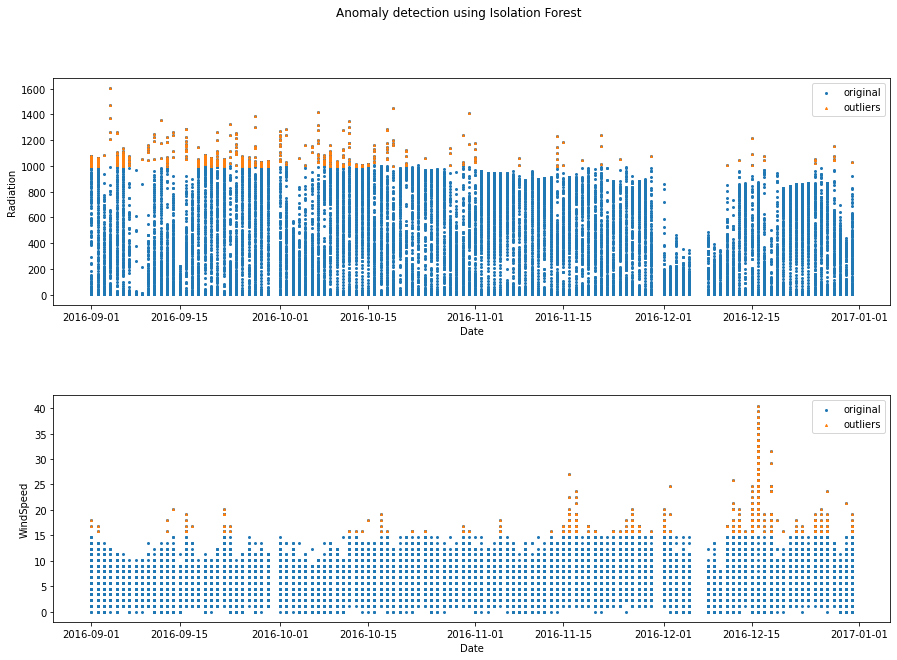

In [134]:
data = outlier_removal(df, ind=-1)